## 1.) IMPORTING LIBRARIES

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

from bs4 import BeautifulSoup
print('Libraries imported.')


Libraries imported.


## 2.) Scraping the wiki page to extract list of London Boroughs along with their population densities and average property prices

In [2]:
response = requests.get('https://en.wikipedia.org/wiki/List_of_London_boroughs').text
data = BeautifulSoup(response,'html.parser')

borough_table = data.find_all("table")[0]
borough_table_rows = borough_table.find_all('tr')[1:]

Borough_df = pd.DataFrame(columns=['Borough','Population Density (/sq km)'])

In [3]:
for i in borough_table_rows:
    borough_name = i.td.text.strip()
    
    base_url = "https://en.wikipedia.org"
    borough_url = base_url + (i.td.a['href'])
    
    response_2 = requests.get(borough_url).text
    data_2 = BeautifulSoup(response_2,'html.parser')
    
    density = 0
    x = data_2.find_all('tr')
    
    try:
        for i in x:
            try:
                temp_string = i.th.string.strip().split()[-1]
            except AttributeError:
                pass
        
            if(temp_string=='Density'):
                num = (i.td.text.split('(')[1])
                density = int(num.split('/')[0].replace(',',''))
                break
        
        Borough_df = Borough_df.append({'Borough':borough_name,'Population Density (/sq km)':density},ignore_index=True)
        
    except:
        pass

In [4]:
Borough_df = Borough_df.append({'Borough':'Barnet','Population Density (/sq km)':4600},ignore_index=True)
Borough_df = Borough_df.append({'Borough':'Kingston upon Thames','Population Density (/sq km)':4800},ignore_index=True)
Borough_df['Borough'][0] = "Barking and Dagenham"
Borough_df['Borough'][8] = "Greenwich"
Borough_df['Borough'][10] = "Hammersmith and Fulham"

In [5]:
Borough_df.head()

,Borough,Population Density (/sq km)
0,Barking and Dagenham,5900
1,Bexley,4100
2,Brent,7600
3,Bromley,2200
4,Camden,12000


### Till here we've obtained a list of London boroughs with their respective population densities 

### I'll now scrape the foxtons.co.uk website tho extract the average property price in each borough

In [6]:
Neighborhood_dict = {'Waltham Forest':'walthamstow','Tower Hamlets':'whitechapel','Redbridge':'wanstead','Newham':'woolwich','Lambeth':'brixton','Hillingdon':'ickenham','Havering':'romford','Haringey':'tottenham','Brent':'wembley','Bexley':'upton'}
Borough_df['Avg Property Price(GBP)'] = 0
for borough in Borough_df['Borough']:
    name = borough.split()[0]
    url = 'https://www.foxtons.co.uk/living-in/'+name
    response_3 = requests.get(url).text
    data_3 = BeautifulSoup(response_3,'html.parser')
    title = data_3.title.text.split()[0]
    if(title!='London'):
        price = int(data_3.find_all(class_='price_headline')[0].text.replace(',','')[1:])
        Borough_df['Avg Property Price(GBP)'][Borough_df['Borough']==borough] = price
    else:
        url = 'https://www.foxtons.co.uk/living-in/'+Neighborhood_dict[borough]
        response_3 = requests.get(url).text
        data_3 = BeautifulSoup(response_3,'html.parser')
        price = int(data_3.find_all(class_='price_headline')[0].text.replace(',','')[1:])
        Borough_df['Avg Property Price(GBP)'][Borough_df['Borough']==borough] = price

C:\Users\prana\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\prana\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
Borough_df.head()

,Borough,Population Density (/sq km),Avg Property Price(GBP)
0,Barking and Dagenham,5900,326431
1,Bexley,4100,466014
2,Brent,7600,502039
3,Bromley,2200,529732
4,Camden,12000,1043123


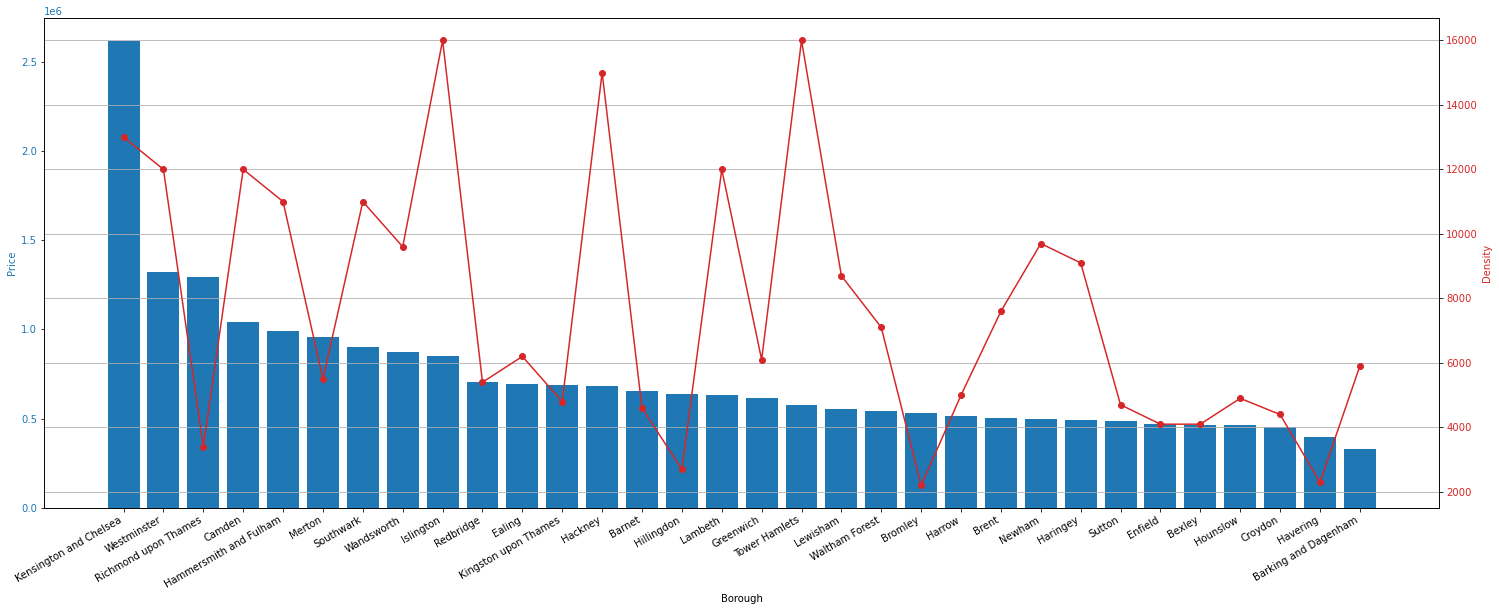

In [10]:
Borough_df.sort_values(by='Avg Property Price(GBP)',ascending=False,inplace=True)
Borough_df.reset_index(inplace=True,drop=True)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Borough')
ax1.set_ylabel('Price', color=color)
ax1.bar(Borough_df['Borough'],Borough_df['Avg Property Price(GBP)'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Density', color=color)  # we already handled the x-label with ax1
ax2.plot(Borough_df['Borough'],Borough_df['Population Density (/sq km)'], color=color,marker='o')
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.autofmt_xdate() #rotates the xlabel to precent overlapping
plt.rcParams['figure.figsize'] = (25,20)
plt.grid()
plt.show()

### Let's assume the customer's budget lies between GBP 600000 and GBP 900000. Also, we would want the population density to be moderate to high as a low density would mean low footfall and a high density would probably lead to difficulty in finding space to open a restaurant. Refering to the above graph, the <b>London borough of Hammersmith and Fulham</b> and Camden seem to be reasonable choices.

### The next step is to obtain the coordinates of each district, which we're accomplishing using the geopy library

In [61]:
HNF_districts = pd.DataFrame(columns=['District','Latitude','Longitude'])
Camden_districts = pd.DataFrame(columns=['District','Latitude','Longitude'])

In [31]:
response_district = requests.get('https://en.wikipedia.org/wiki/London_Borough_of_Hammersmith_and_Fulham#Districts').text
data = BeautifulSoup(response_district,'html.parser')

response_district_cd = requests.get('https://en.wikipedia.org/wiki/List_of_districts_in_the_London_Borough_of_Camden').text
data_cd = BeautifulSoup(response_district_cd,'html.parser')

In [64]:
lists = data.find_all('li')
for i in lists[124:137]:
    HNF_districts = HNF_districts.append({'District':i.text.split('(')[0]},ignore_index=True)


In [65]:
HNF_districts

,District,Latitude,Longitude
0,Brook Green,NaN,NaN
1,Chelsea Harbour,NaN,NaN
2,College Park,NaN,NaN
3,East Acton,NaN,NaN
4,Fulham,NaN,NaN
5,Hammersmith,NaN,NaN
6,Old Oak Common,NaN,NaN
7,Parsons Green,NaN,NaN
8,Sands End,NaN,NaN
9,Shepherd's Bush,NaN,NaN


In [62]:
lists = data_cd.find_all('tr')
for i in lists[1:26]:
    Camden_districts = Camden_districts.append({'District':i.text.split('\n')[1]},ignore_index=True)

In [63]:
Camden_districts

,District,Latitude,Longitude
0,Belsize Park,NaN,NaN
1,Bloomsbury,NaN,NaN
2,Camden Town,NaN,NaN
3,Chalk Farm,NaN,NaN
4,Covent Garden,NaN,NaN
5,Dartmouth Park,NaN,NaN
6,Fitzrovia,NaN,NaN
7,Fortune Green,NaN,NaN
8,Frognal,NaN,NaN
9,Gospel Oak,NaN,NaN


In [71]:
for i in HNF_districts['District']:
    address = i + ',London'

    geolocator = Nominatim(user_agent="london_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of', i,'are {}, {}.'.format(latitude, longitude))
    HNF_districts['Latitude'][HNF_districts['District']==i] = latitude
    HNF_districts['Longitude'][HNF_districts['District']==i] = longitude

The geograpical coordinate of Brook Green are 51.4960214, -0.2192533.
The geograpical coordinate of Chelsea Harbour  are 51.47536985, -0.18104674292671608.
The geograpical coordinate of College Park are 51.5311515, -0.2353698.
The geograpical coordinate of East Acton are 51.5173451, -0.248137.
The geograpical coordinate of Fulham are 51.4744221, -0.2060772.
The geograpical coordinate of Hammersmith are 51.4920377, -0.2236401.
The geograpical coordinate of Old Oak Common are 51.5279486, -0.2470894.
The geograpical coordinate of Parsons Green are 51.4750837, -0.201549.
The geograpical coordinate of Sands End are 51.4725454, -0.1871122.
The geograpical coordinate of Shepherd's Bush are 51.5053155, -0.2229856.
The geograpical coordinate of Walham Green are 51.4813433, -0.1950367.
The geograpical coordinate of West Kensington are 51.4907023, -0.2059442.
The geograpical coordinate of White City are 51.5119347, -0.2242361.


In [72]:
HNF_districts

,District,Latitude,Longitude
0,Brook Green,51.496,-0.219253
1,Chelsea Harbour,51.4754,-0.181047
2,College Park,51.5312,-0.23537
3,East Acton,51.5173,-0.248137
4,Fulham,51.4744,-0.206077
5,Hammersmith,51.492,-0.22364
6,Old Oak Common,51.5279,-0.247089
7,Parsons Green,51.4751,-0.201549
8,Sands End,51.4725,-0.187112
9,Shepherd's Bush,51.5053,-0.222986


In [69]:
for i in Camden_districts['District']:
    address = i + ',London'

    geolocator = Nominatim(user_agent="london_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of', i,'are {}, {}.'.format(latitude, longitude))
    Camden_districts['Latitude'][Camden_districts['District']==i] = latitude
    Camden_districts['Longitude'][Camden_districts['District']==i] = longitude

The geograpical coordinate of Belsize Park are 51.5473926, -0.1683005.
The geograpical coordinate of Bloomsbury are 51.5210963, -0.1289635.
The geograpical coordinate of Camden Town are 51.5423045, -0.1395604.
The geograpical coordinate of Chalk Farm are 51.5441141, -0.1534811.
The geograpical coordinate of Covent Garden are 51.512873600000006, -0.12254367918576929.
The geograpical coordinate of Dartmouth Park are 51.5616497, -0.13926208500083243.
The geograpical coordinate of Fitzrovia are 51.5187642, -0.1410017.
The geograpical coordinate of Fortune Green are 51.5545991, -0.1976553773757754.
The geograpical coordinate of Frognal are 51.5496303, -0.1811833.
The geograpical coordinate of Gospel Oak are 51.5554865, -0.151577.
The geograpical coordinate of Hampstead are 51.5580835, -0.1737206.
The geograpical coordinate of Haverstock are 51.54483195, -0.153193182845633.
The geograpical coordinate of Highgate are 51.5744322, -0.1526837.
The geograpical coordinate of Holborn are 51.5195982

In [70]:
Camden_districts

,District,Latitude,Longitude
0,Belsize Park,51.5474,-0.1683
1,Bloomsbury,51.5211,-0.128964
2,Camden Town,51.5423,-0.13956
3,Chalk Farm,51.5441,-0.153481
4,Covent Garden,51.5129,-0.122544
5,Dartmouth Park,51.5616,-0.139262
6,Fitzrovia,51.5188,-0.141002
7,Fortune Green,51.5546,-0.197655
8,Frognal,51.5496,-0.181183
9,Gospel Oak,51.5555,-0.151577


In [73]:
location = geolocator.geocode('London,United Kingdom')
latitude_hnf = location.latitude
longitude_hnf = location.longitude

map_hnf = folium.Map(location=[latitude_hnf, longitude_hnf], zoom_start=10)
# add markers to map
for lat, lng, neighborhood in zip(HNF_districts['Latitude'], HNF_districts['Longitude'], HNF_districts['District']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hnf)  
    
map_hnf

In [74]:
location = geolocator.geocode('London,United Kingdom')
latitude_cd = location.latitude
longitude_cd = location.longitude

map_cd = folium.Map(location=[latitude_cd, longitude_cd], zoom_start=10)
# add markers to map
for lat, lng, neighborhood in zip(Camden_districts['Latitude'], Camden_districts['Longitude'], Camden_districts['District']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cd)  
    
map_cd

## 3.) Obtaining the list of restaurants in each district using Foursquare API

In [75]:
CLIENT_ID = 'WKFAVNAIRLPPY5USSMN31PYXFLYTO1XKLGH04V50RBXVMXO1' # your Foursquare ID
CLIENT_SECRET = 'Z3LRCUNWXAQSKWAN5HCLJVYZIMGFKCWI54WH3BQJFDJQ5ZHB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
RADIUS = 500
SECTION = 'food'

url = 'https://api.foursquare.com/v2/venues/explore'
para = {'radius':RADIUS,'section':SECTION,'client_id':CLIENT_ID,'client_secret':CLIENT_SECRET,'v':VERSION,'limit':500,'llAcc':10}

Neighborhood_df = pd.DataFrame(columns = ['District','Restaurant Name','Category'])



In [90]:
Combined_districts = pd.concat([HNF_districts,Camden_districts])

In [91]:
Combined_districts.reset_index(inplace=True,drop=True)

In [92]:
Combined_districts

,District,Latitude,Longitude
0,Brook Green,51.496,-0.219253
1,Chelsea Harbour,51.4754,-0.181047
2,College Park,51.5312,-0.23537
3,East Acton,51.5173,-0.248137
4,Fulham,51.4744,-0.206077
5,Hammersmith,51.492,-0.22364
6,Old Oak Common,51.5279,-0.247089
7,Parsons Green,51.4751,-0.201549
8,Sands End,51.4725,-0.187112
9,Shepherd's Bush,51.5053,-0.222986


In [93]:
for row in Combined_districts.values:
    try:
        district = row[0]
        para['ll'] = ('{},{}'.format(row[1],row[2]))
        results = requests.get(url,params=para).json()
        for i in results['response']['groups'][0]['items']:
            rest_name = i['venue']['name']
            rest_category = i['venue']['categories'][0]['shortName'] 
            Neighborhood_df = Neighborhood_df.append({'District':district,'Restaurant Name':rest_name,'Category':rest_category},ignore_index=True)
    except IndexError:
        pass

In [94]:
Neighborhood_df.shape

(1395, 3)

In [95]:
len(Neighborhood_df['Restaurant Name'].unique())

954

In [96]:
Neighborhood_df = Neighborhood_df[~(Neighborhood_df['Category'].isin(['Restaurant','Office','Advertising Agency','Tour Provider']))]
Neighborhood_df.reset_index(inplace=True,drop=True)

In [97]:
len(Neighborhood_df['Restaurant Name'].unique())

915

In [98]:
Neighborhood_df = Neighborhood_df.drop_duplicates(keep='first',subset='Restaurant Name')

In [99]:
Neighborhood_df.shape

(915, 3)

In [100]:
Neighborhood_df.reset_index(inplace=True)
Neighborhood_df.tail(15)

,index,District,Restaurant Name,Category
900,1330,West Hampstead,Bobby Fitzpatrick,Pizza
901,1331,West Hampstead,The Wet Fish Cafe,Café
902,1332,West Hampstead,Pisu,Café
903,1333,West Hampstead,Toomai,Vietnamese
904,1334,West Hampstead,Rosa's Thai Cafe,Thai
905,1336,West Hampstead,Bellaluna,Italian
906,1337,West Hampstead,Hām,English
907,1338,West Hampstead,Banana Tree Canteen,Thai
908,1339,West Hampstead,Guglee,Indian
909,1340,West Hampstead,Czech & Slovak Bar & Restaurant,Czech


### The next step here is to one hot encode the restaurant categories for model building purpose

In [101]:
# one hot encoding
neighborhood_onehot = pd.get_dummies(Neighborhood_df[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neighborhood_onehot['District'] = Neighborhood_df['District'] 

# move neighborhood column to the first column
fixed_columns = [neighborhood_onehot.columns[-1]] + list(neighborhood_onehot.columns[:-1])
neighborhood_onehot = neighborhood_onehot[fixed_columns]

neighborhood_onehot.head()

,District,African,American,Argentinian,Asian,Australian,BBQ,Bagels,Bakery,Bistro,Brasserie,Brazilian,Breakfast,Burgers,Burritos,Cafeteria,Café,Cantonese,Caribbean,Chinese,Creperie,Czech,Deli / Bodega,Dim Sum,Diner,Donuts,Dumplings,English,Ethiopian,Falafel,Fast Food,Fish & Chips,Food,Food Court,Food Stand,Food Truck,French,Fried Chicken,Gastropub,German,Gluten-free,Greek,Halal,Himalayan,Indian,Irish,Israeli,Italian,Japanese,Japanese Curry,Kebab,Korean,Kosher,Lebanese,Malay,Mediterranean,Mexican,Middle Eastern,Modern European,Moroccan,New American,Noodles,North Indian,Okonomiyaki,Pakistani,Persian,Peruvian,Pizza,Poke Place,Portuguese,Ramen,Salad,Sandwiches,Scandinavian,Seafood,Snacks,Soup,South American,Spanish,Sri Lankan,Steakhouse,Sushi,Szechuan,Tapas,Thai,Turkish,Udon,Vegetarian / Vegan,Vietnamese,Wings,Yoshoku
0,Brook Green,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Brook Green,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Brook Green,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,Brook Green,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Brook Green,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [182]:
neighborhood_grouped = neighborhood_onehot.groupby('District').sum().reset_index()
neighborhood_grouped
# Grouping by neighborhood

,District,African,American,Argentinian,Asian,Australian,BBQ,Bagels,Bakery,Bistro,Brasserie,Brazilian,Breakfast,Burgers,Burritos,Cafeteria,Café,Cantonese,Caribbean,Chinese,Creperie,Czech,Deli / Bodega,Dim Sum,Diner,Donuts,Dumplings,English,Ethiopian,Falafel,Fast Food,Fish & Chips,Food,Food Court,Food Stand,Food Truck,French,Fried Chicken,Gastropub,German,Gluten-free,Greek,Halal,Himalayan,Indian,Irish,Israeli,Italian,Japanese,Japanese Curry,Kebab,Korean,Kosher,Lebanese,Malay,Mediterranean,Mexican,Middle Eastern,Modern European,Moroccan,New American,Noodles,North Indian,Okonomiyaki,Pakistani,Persian,Peruvian,Pizza,Poke Place,Portuguese,Ramen,Salad,Sandwiches,Scandinavian,Seafood,Snacks,Soup,South American,Spanish,Sri Lankan,Steakhouse,Sushi,Szechuan,Tapas,Thai,Turkish,Udon,Vegetarian / Vegan,Vietnamese,Wings,Yoshoku
0,Belsize Park,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,6,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,3,0,1,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,Bloomsbury,0,0,0,1,0,0,0,2,1,0,0,1,2,0,0,6,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2,Brook Green,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,2,1,0,0,0,1,0
3,Camden Town,1,1,0,1,0,1,1,0,0,0,0,1,2,0,0,6,0,3,1,0,0,0,0,2,0,0,0,0,1,1,1,0,0,1,2,1,1,0,0,0,0,0,0,1,1,0,5,1,0,1,1,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,3,2,0,0
4,Chalk Farm,0,0,0,1,0,0,0,3,0,0,1,1,1,1,1,11,0,1,0,0,0,1,0,0,0,0,0,0,2,1,2,0,0,0,0,2,1,0,0,0,1,0,0,0,0,0,4,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
5,Chelsea Harbour,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,2,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,College Park,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0
7,Covent Garden,0,2,0,1,0,0,0,5,0,1,0,2,0,0,0,4,0,0,1,0,0,2,0,0,0,0,2,0,0,0,2,0,1,0,0,4,2,0,0,0,0,0,0,3,1,0,4,1,1,0,3,0,0,0,2,1,0,1,0,0,2,1,0,0,0,1,2,0,0,3,1,0,0,3,0,0,0,1,0,4,2,0,1,0,1,0,1,0,0,0
8,Dartmouth Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9,East Acton,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [183]:
common_themes = neighborhood_grouped.sum(axis=0)[1:]

In [184]:
common_themes = common_themes.sort_values()

In [185]:
most_common_themes = list(common_themes[common_themes > 2].index)

In [186]:
most_common_themes

['Szechuan',
 'Persian',
 'African',
 'Argentinian',
 'Dim Sum',
 'BBQ',
 'Bagels',
 'Bistro',
 'Salad',
 'Diner',
 'Creperie',
 'Ramen',
 'Peruvian',
 'Caribbean',
 'Spanish',
 'Malay',
 'Lebanese',
 'Irish',
 'Kebab',
 'Donuts',
 'Fried Chicken',
 'Food Court',
 'Mediterranean',
 'Brazilian',
 'Modern European',
 'American',
 'Asian',
 'Mexican',
 'Burritos',
 'Vegetarian / Vegan',
 'Fish & Chips',
 'Turkish',
 'Greek',
 'Falafel',
 'Steakhouse',
 'Korean',
 'Vietnamese',
 'Seafood',
 'English',
 'Tapas',
 'Food Truck',
 'Fast Food',
 'Sushi',
 'Middle Eastern',
 'Deli / Bodega',
 'Breakfast',
 'Sandwiches',
 'Burgers',
 'Gastropub',
 'Thai',
 'Chinese',
 'Japanese',
 'French',
 'Pizza',
 'Bakery',
 'Indian',
 'Italian',
 'Café']

In [187]:
cols_to_select = ['District']
cols_to_select.extend(most_common_themes)

In [188]:
cols_to_select

['District',
 'Szechuan',
 'Persian',
 'African',
 'Argentinian',
 'Dim Sum',
 'BBQ',
 'Bagels',
 'Bistro',
 'Salad',
 'Diner',
 'Creperie',
 'Ramen',
 'Peruvian',
 'Caribbean',
 'Spanish',
 'Malay',
 'Lebanese',
 'Irish',
 'Kebab',
 'Donuts',
 'Fried Chicken',
 'Food Court',
 'Mediterranean',
 'Brazilian',
 'Modern European',
 'American',
 'Asian',
 'Mexican',
 'Burritos',
 'Vegetarian / Vegan',
 'Fish & Chips',
 'Turkish',
 'Greek',
 'Falafel',
 'Steakhouse',
 'Korean',
 'Vietnamese',
 'Seafood',
 'English',
 'Tapas',
 'Food Truck',
 'Fast Food',
 'Sushi',
 'Middle Eastern',
 'Deli / Bodega',
 'Breakfast',
 'Sandwiches',
 'Burgers',
 'Gastropub',
 'Thai',
 'Chinese',
 'Japanese',
 'French',
 'Pizza',
 'Bakery',
 'Indian',
 'Italian',
 'Café']

In [189]:
#Dropping the least common restaurant themes
neighborhood_grouped = neighborhood_grouped[cols_to_select]

In [190]:
neighborhood_grouped

,District,Szechuan,Persian,African,Argentinian,Dim Sum,BBQ,Bagels,Bistro,Salad,Diner,Creperie,Ramen,Peruvian,Caribbean,Spanish,Malay,Lebanese,Irish,Kebab,Donuts,Fried Chicken,Food Court,Mediterranean,Brazilian,Modern European,American,Asian,Mexican,Burritos,Vegetarian / Vegan,Fish & Chips,Turkish,Greek,Falafel,Steakhouse,Korean,Vietnamese,Seafood,English,Tapas,Food Truck,Fast Food,Sushi,Middle Eastern,Deli / Bodega,Breakfast,Sandwiches,Burgers,Gastropub,Thai,Chinese,Japanese,French,Pizza,Bakery,Indian,Italian,Café
0,Belsize Park,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,1,0,2,3,3,6
1,Bloomsbury,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2,0,0,1,0,0,0,0,1,0,0,0,1,1,0,2,0,1,1,1,2,0,2,0,0,6
2,Brook Green,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,1,0,2,2,1,0,1,1,1,1,2,4
3,Camden Town,0,0,1,0,0,1,1,0,0,2,0,1,0,3,0,2,0,1,1,0,1,0,0,0,0,1,1,1,0,3,1,0,0,1,0,1,2,0,0,1,2,1,1,0,0,1,0,2,0,0,1,1,1,1,0,1,5,6
4,Chalk Farm,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,1,1,2,0,1,2,0,0,0,1,0,0,0,1,1,1,1,1,0,1,0,0,0,1,2,2,3,0,4,11
5,Chelsea Harbour,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,0,1,0,0,0,0,0,0,1,2,1
6,College Park,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,1,0,0,0
7,Covent Garden,0,0,0,0,0,0,0,0,1,0,0,3,1,0,1,0,0,1,0,0,2,1,2,0,1,2,1,1,0,1,2,1,0,0,4,3,0,3,2,1,0,0,2,0,2,2,0,0,0,0,1,1,4,2,5,3,4,4
8,Dartmouth Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,1
9,East Acton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0


In [191]:
# Building the KMeans CLustering Model
### set number of clusters
kclusters = 3

neighborhood_grouped_clustering = neighborhood_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighborhood_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 2, 0, 1, 2, 0, 1, 1,
       1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1])

In [192]:
neighborhood_final = pd.DataFrame(columns = ['District','Cluster'])
neighborhood_final['District'] = neighborhood_grouped['District']
neighborhood_final['Cluster'] = kmeans.labels_
neighborhood_final['Most Common Theme'] = ''
neighborhood_final['2nd Most Common Theme'] = ''
neighborhood_final['3rd Most Common Theme'] = ''
neighborhood_final['4th Most Common Theme'] = ''

In [193]:
neighborhood_final

,District,Cluster,Most Common Theme,2nd Most Common Theme,3rd Most Common Theme,4th Most Common Theme
0,Belsize Park,0,,,,
1,Bloomsbury,0,,,,
2,Brook Green,1,,,,
3,Camden Town,0,,,,
4,Chalk Farm,0,,,,
5,Chelsea Harbour,1,,,,
6,College Park,1,,,,
7,Covent Garden,0,,,,
8,Dartmouth Park,1,,,,
9,East Acton,1,,,,


In [194]:
for i in neighborhood_grouped.values:
    maxidx = np.argsort(i[1:])[-1] 
    maxidx_2 = np.argsort(i[1:])[-2] 
    maxidx_3 = np.argsort(i[1:])[-3] 
    maxidx_4 = np.argsort(i[1:])[-4] 
    most_common_theme = (neighborhood_grouped.columns[maxidx+1])
    most_common_theme_2 = (neighborhood_grouped.columns[maxidx_2+1])
    most_common_theme_3 = (neighborhood_grouped.columns[maxidx_3+1])
    most_common_theme_4 = (neighborhood_grouped.columns[maxidx_4+1])
    district = i[0]
    neighborhood_final['Most Common Theme'][neighborhood_final['District']==district] = most_common_theme    
    neighborhood_final['2nd Most Common Theme'][neighborhood_final['District']==district] = most_common_theme_2 
    neighborhood_final['3rd Most Common Theme'][neighborhood_final['District']==district] = most_common_theme_3 
    neighborhood_final['4th Most Common Theme'][neighborhood_final['District']==district] = most_common_theme_4 

C:\Users\prana\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\prana\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\prana\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [195]:
neighborhood_final[neighborhood_final['Cluster']==0]

,District,Cluster,Most Common Theme,2nd Most Common Theme,3rd Most Common Theme,4th Most Common Theme
0,Belsize Park,0,Café,Indian,Italian,Bakery
1,Bloomsbury,0,Café,Greek,Bakery,French
3,Camden Town,0,Café,Italian,Caribbean,Vegetarian / Vegan
4,Chalk Farm,0,Café,Italian,Bakery,Pizza
7,Covent Garden,0,Bakery,Café,Steakhouse,French
10,Fitzrovia,0,Italian,Café,Bakery,Japanese
13,Fulham,0,Italian,Café,Pizza,Bakery
16,Hampstead,0,Café,Italian,Bakery,Japanese
19,Kentish Town,0,Café,Indian,Italian,French
32,West End of London,0,Café,Italian,Vietnamese,Chinese


In [196]:
neighborhood_final[neighborhood_final['Cluster']==1]

,District,Cluster,Most Common Theme,2nd Most Common Theme,3rd Most Common Theme,4th Most Common Theme
2,Brook Green,1,Café,Italian,Thai,Gastropub
5,Chelsea Harbour,1,Italian,Sandwiches,Café,Gastropub
6,College Park,1,Brazilian,Thai,Deli / Bodega,Spanish
8,Dartmouth Park,1,Italian,Café,Fast Food,Gastropub
9,East Acton,1,Chinese,Bakery,Fish & Chips,Falafel
11,Fortune Green,1,Café,Indian,Middle Eastern,Fish & Chips
12,Frognal,1,Café,Japanese,Chinese,Persian
14,Gospel Oak,1,Café,Gastropub,Breakfast,Italian
17,Highgate,1,Café,Indian,Gastropub,Caribbean
20,Kings Cross,1,Café,Italian,Breakfast,Burgers


In [197]:
neighborhood_final[neighborhood_final['Cluster']==2]

,District,Cluster,Most Common Theme,2nd Most Common Theme,3rd Most Common Theme,4th Most Common Theme
15,Hammersmith,2,Café,Pizza,Sandwiches,Burgers
18,Holborn,2,Café,Sandwiches,Food Truck,French
24,Shepherd's Bush,2,Café,Chinese,Fast Food,Indian
27,St Pancras,2,Café,Sandwiches,Indian,Italian
